In [1]:
import os
import pandas as pd

HORNSGATAN_HOME = os.environ["HORNSGATAN_HOME"]
os.chdir(HORNSGATAN_HOME)
print("Current directory:", os.getcwd())

from src.tools import mytools


date = "2020-01-02"
detector = "w2e_out"
path  = "data/daily_splitted_data/"


Current directory: /home/kaveh/projects/Hornsgatan


In [2]:
data = pd.read_csv(f"{path}data_{date}.csv")
data.head()

,detector_id,time_detector_real,speed_detector_real,day,date
0,e2w_in,1577923226,48,Thursday,2020-01-02
1,e2w_in,1577923230,43,Thursday,2020-01-02
2,w2e_in,1577923232,31,Thursday,2020-01-02
3,e2w_in,1577923233,32,Thursday,2020-01-02
4,e2w_in,1577923235,32,Thursday,2020-01-02


In [3]:
data = data[data["detector_id"]==detector]
data.head()

,detector_id,time_detector_real,speed_detector_real,day,date
13,w2e_out,1577923284,27,Thursday,2020-01-02
15,w2e_out,1577923285,29,Thursday,2020-01-02
22,w2e_out,1577923299,15,Thursday,2020-01-02
87,w2e_out,1577923494,12,Thursday,2020-01-02
135,w2e_out,1577923699,43,Thursday,2020-01-02


In [4]:
len(data)

1249

In [5]:
from src.tools import mytools


In [6]:
#mytools.delete_all_except_list(f"data/calibration_intermediate_data/", [".gitkeep"])

In [7]:
# Add a new column for the difference in time_detector_real with the previous row
data['delta_time_detector_real'] = data['time_detector_real'].diff()

# Display the first few rows to check the new column
data.head()

,detector_id,time_detector_real,speed_detector_real,day,date,delta_time_detector_real
13,w2e_out,1577923284,27,Thursday,2020-01-02,NaN
15,w2e_out,1577923285,29,Thursday,2020-01-02,1.0
22,w2e_out,1577923299,15,Thursday,2020-01-02,14.0
87,w2e_out,1577923494,12,Thursday,2020-01-02,195.0
135,w2e_out,1577923699,43,Thursday,2020-01-02,205.0


In [8]:
data['time_hms'] = pd.to_datetime(data['time_detector_real'], unit='s').dt.time
data['hour'] = pd.to_datetime(data['time_detector_real'], unit='s').dt.hour
data.set_index('time_hms', inplace=True)


## Outlier Analysis on `speed_detector_real`
We analyze the `speed_detector_real` column to detect and visualize outliers in the speed measurements.

Number of outliers: 9


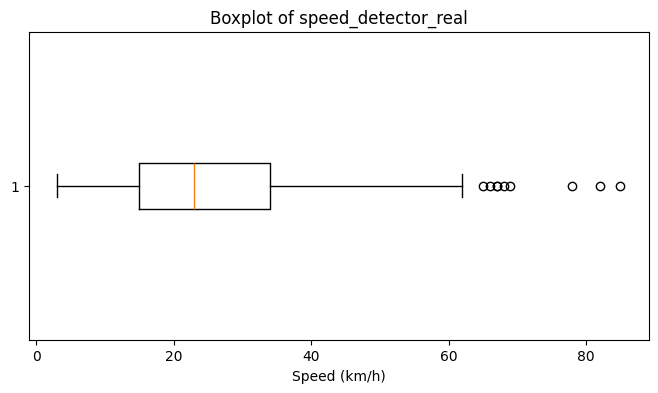

,detector_id,time_detector_real,speed_detector_real,day,date,delta_time_detector_real,hour
time_hms,,,,,,,
01:46:07,w2e_out,1577929567,69,Thursday,2020-01-02,86.0,1
05:08:38,w2e_out,1577941718,65,Thursday,2020-01-02,420.0,5
07:08:14,w2e_out,1577948894,66,Thursday,2020-01-02,86.0,7
08:54:18,w2e_out,1577955258,67,Thursday,2020-01-02,58.0,8
10:25:05,w2e_out,1577960705,67,Thursday,2020-01-02,23.0,10
18:11:58,w2e_out,1577988718,68,Thursday,2020-01-02,107.0,18
20:24:46,w2e_out,1577996686,82,Thursday,2020-01-02,47.0,20
20:24:47,w2e_out,1577996687,85,Thursday,2020-01-02,1.0,20
21:48:34,w2e_out,1578001714,78,Thursday,2020-01-02,149.0,21


In [9]:
import matplotlib.pyplot as plt

# Calculate IQR
Q1 = data['speed_detector_real'].quantile(0.25)
Q3 = data['speed_detector_real'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = data[(data['speed_detector_real'] < lower_bound) | (data['speed_detector_real'] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")

# Visualize with a boxplot
plt.figure(figsize=(8, 4))
plt.boxplot(data['speed_detector_real'], vert=False)
plt.title('Boxplot of speed_detector_real')
plt.xlabel('Speed (km/h)')
plt.show()

# Optionally, display outlier rows
outliers

The boxplot above shows the distribution of `speed_detector_real` values. Points outside the whiskers are considered outliers according to the IQR rule. The table below lists a few detected outliers.


In [10]:
# Mark outliers in the main DataFrame
data['is_outlier'] = (data['speed_detector_real'] < lower_bound) | (data['speed_detector_real'] > upper_bound)

# Describe delta_time_detector_real for outliers and non-outliers
outlier_deltas = data[data['is_outlier']]['delta_time_detector_real']
non_outlier_deltas = data[~data['is_outlier']]['delta_time_detector_real']

print("Outliers - delta_time_detector_real stats:")
print(outlier_deltas.describe())
print("\nNon-Outliers - delta_time_detector_real stats:")
print(non_outlier_deltas.describe())

Outliers - delta_time_detector_real stats:
count      9.000000
mean     108.555556
std      124.943098
min        1.000000
25%       47.000000
50%       86.000000
75%      107.000000
max      420.000000
Name: delta_time_detector_real, dtype: float64

Non-Outliers - delta_time_detector_real stats:
count    1239.000000
mean       68.644875
std       108.584555
min         1.000000
25%         9.000000
50%        37.000000
75%        82.000000
max      1145.000000
Name: delta_time_detector_real, dtype: float64


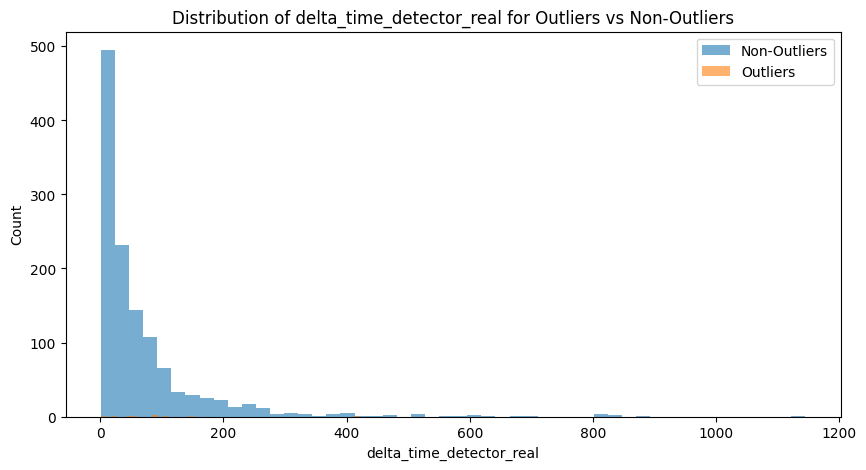

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(non_outlier_deltas.dropna(), bins=50, alpha=0.6, label='Non-Outliers')
plt.hist(outlier_deltas.dropna(), bins=50, alpha=0.6, label='Outliers')
plt.xlabel('delta_time_detector_real')
plt.ylabel('Count')
plt.title('Distribution of delta_time_detector_real for Outliers vs Non-Outliers')
plt.legend()
plt.show()

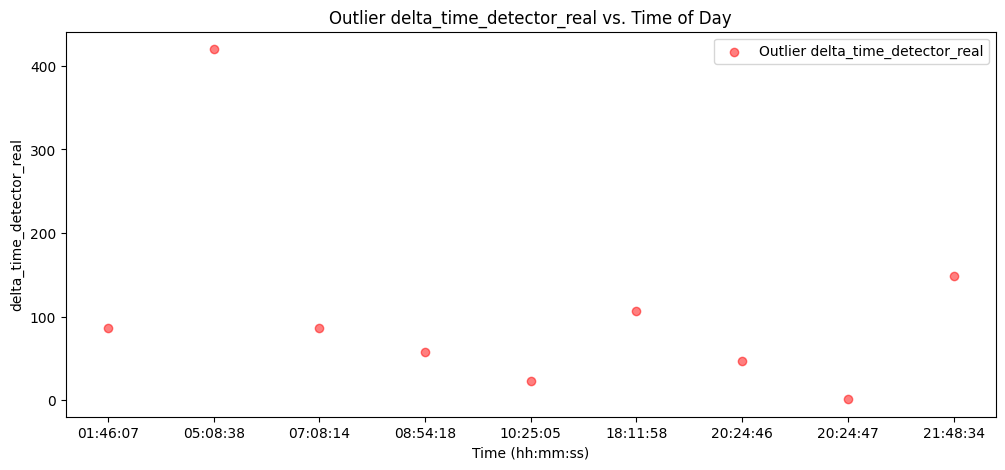

In [12]:
data = data.reset_index()

plt.figure(figsize=(12,5))
plt.scatter(
    data[data['is_outlier']]['time_hms'].apply(str),
    data[data['is_outlier']]['delta_time_detector_real'],
    c='red',
    alpha=0.5,
    label='Outlier delta_time_detector_real'
)
plt.xlabel('Time (hh:mm:ss)')
plt.ylabel('delta_time_detector_real')
plt.title('Outlier delta_time_detector_real vs. Time of Day')
plt.legend()
plt.show()

In [13]:
data.head()

,time_hms,detector_id,time_detector_real,speed_detector_real,day,date,delta_time_detector_real,hour,is_outlier
0,00:01:24,w2e_out,1577923284,27,Thursday,2020-01-02,NaN,0,False
1,00:01:25,w2e_out,1577923285,29,Thursday,2020-01-02,1.0,0,False
2,00:01:39,w2e_out,1577923299,15,Thursday,2020-01-02,14.0,0,False
3,00:04:54,w2e_out,1577923494,12,Thursday,2020-01-02,195.0,0,False
4,00:08:19,w2e_out,1577923699,43,Thursday,2020-01-02,205.0,0,False


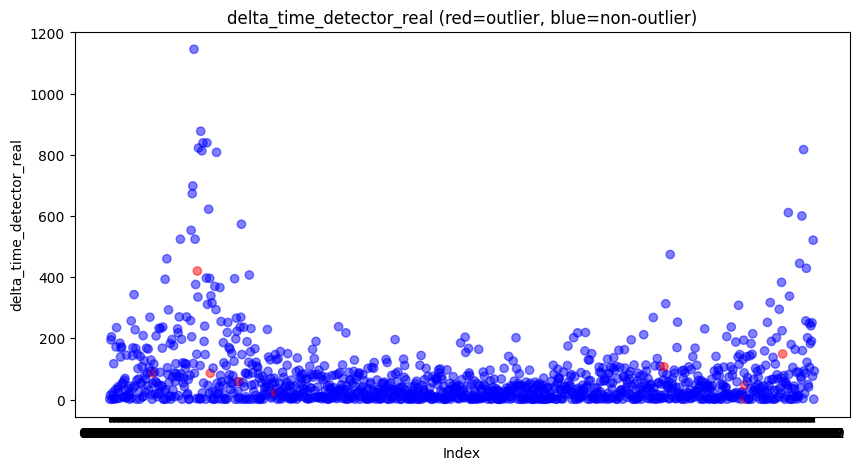

In [14]:
plt.figure(figsize=(10,5))
plt.scatter(data['time_hms'].apply(str),
            data['delta_time_detector_real'], 
            c=data['is_outlier'].map({True: 'red', False: 'blue'}), 
            alpha=0.5, label='delta_time_detector_real')
plt.xlabel('Index')
plt.ylabel('delta_time_detector_real')
plt.title('delta_time_detector_real (red=outlier, blue=non-outlier)')
plt.show()

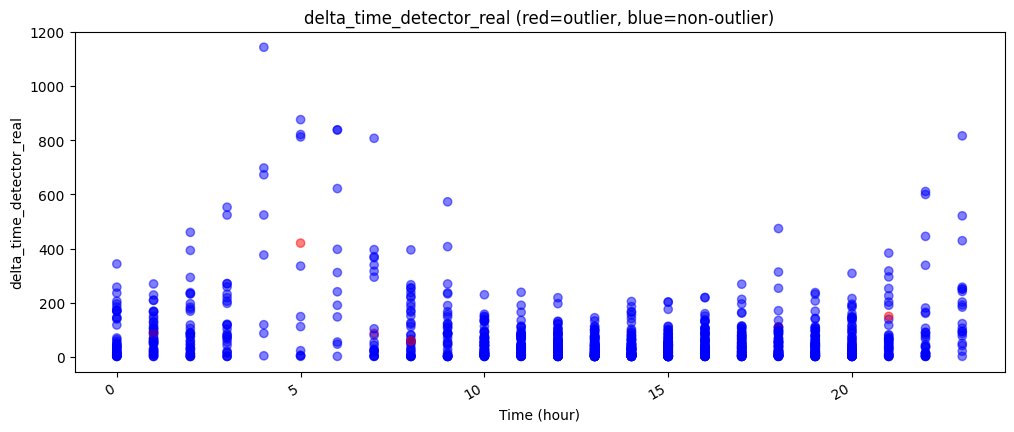

In [15]:
import matplotlib.dates as mdates

plt.figure(figsize=(12,5))
plt.scatter(
    data['hour'],  # Use datetime, not string
    data['delta_time_detector_real'],
    c=data['is_outlier'].map({True: 'red', False: 'blue'}),
    alpha=0.5,
    label='delta_time_detector_real'
)
plt.xlabel('Time (hour)')
plt.ylabel('delta_time_detector_real')
plt.title('delta_time_detector_real (red=outlier, blue=non-outlier)')

# Format x-axis to show only time
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()  # Auto-format date labels
plt.show()

<Figure size 1400x600 with 0 Axes>

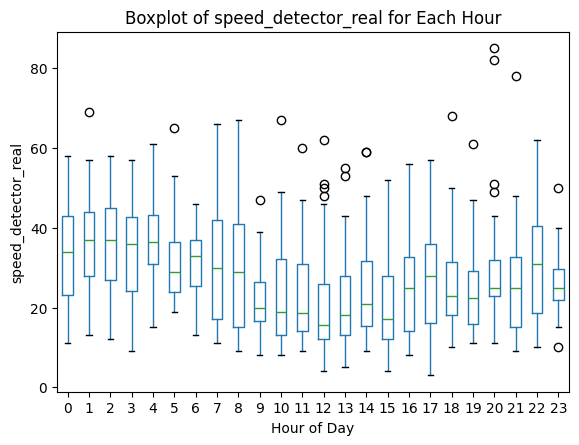

In [16]:
plt.figure(figsize=(14,6))
data.boxplot(column='speed_detector_real', by='hour', grid=False)
plt.xlabel('Hour of Day')
plt.ylabel('speed_detector_real')
plt.title('Boxplot of speed_detector_real for Each Hour')
plt.suptitle('')  # Remove the automatic 'Boxplot grouped by hour' title
plt.show()

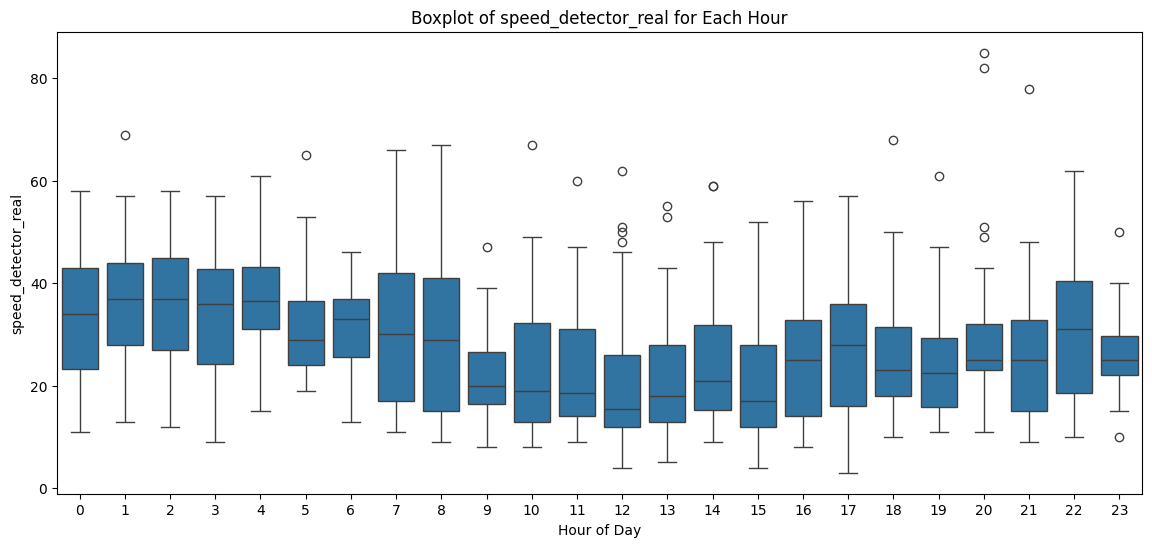

In [17]:
import seaborn as sns

plt.figure(figsize=(14,6))
sns.boxplot(x='hour', y='speed_detector_real', data=data)
plt.xlabel('Hour of Day')
plt.ylabel('speed_detector_real')
plt.title('Boxplot of speed_detector_real for Each Hour')
plt.show()

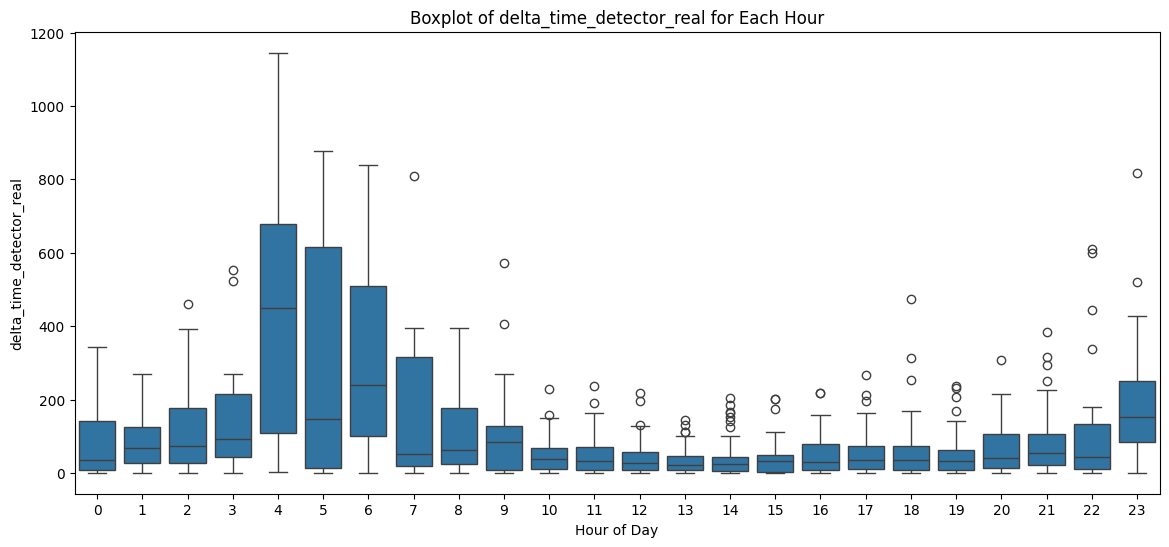

In [18]:
import seaborn as sns

plt.figure(figsize=(14,6))
sns.boxplot(x='hour', y='delta_time_detector_real', data=data)
plt.xlabel('Hour of Day')
plt.ylabel('delta_time_detector_real')
plt.title('Boxplot of delta_time_detector_real for Each Hour')
plt.show()